# Vocab Size와 모델에 따른 고전 머신러닝 성능 비교 실험

[0-1. 플로우 관찰](#플로우-관찰)

[0-2. 모듈화 하기](#모듈화하기)

[1. Multinomial NB](#1.-MultinomialNB)

[2. Complement NB](#2.-ComplementNB)

[3. Logistic Regression](#3.-Logistic-Regression)

[4. Support Vector Machine](#4.-Support-Vector-Machine)

[5. Decision Tree](#5.-Decision-Tree)

[6. Random Forest](#6.-Random-Forest)

[7. Gradient Boosting](#7.-Gradient-Boosting)

[8. Hard Voting](#8.-Hard-Voting)

[회고](#1차-관찰-분석)

-----------------------------------------
간단한 추가 실험:

[8. Soft Voting](#9.-Soft-Voting)

[10. 1D CNN](#10.-1D-CNN)



### 라이브러리 임포트

In [367]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import get_file
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 플로우 관찰

### 로이터 데이터 불러오기

In [8]:
### 단어 개수 설정
num_words = None
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

In [9]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


### 단어 인덱싱

In [13]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [14]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

### 디코딩

In [18]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [19]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

### 단어 벡터화하기: 

1. DTM
2. TF-IDF (사용할 것)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [22]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


### 머신러닝 모델 호출

In [249]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [25]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [26]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


### 모듈화하기

    models = {
        "multinomial_nb": MultinomialNB(),
        "complement_nb": ComplementNB(),
        "logistic_regression": LogisticRegression(max_iter=1000),
        "decision_tree": DecisionTreeClassifier(),
        "random_forest": RandomForestClassifier(n_estimators=100),
        "gradient_boosting": GradientBoostingClassifier(n_estimators=100),
        "linear_svc": LinearSVC()
    }
    
    with Soft/Hard Voting

In [27]:
def decode_reuters(sequences, index_to_word):
    """ 단어 디코딩 """
    return [' '.join([index_to_word.get(index, "<unk>") for index in sequence]) for sequence in sequences]

In [256]:
def ML(num_words=10000, model_name=None):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    
    word_index = reuters.get_word_index()
    index_to_word = {index + 3: word for word, index in word_index.items()}
    index_to_word[0], index_to_word[1], index_to_word[2] = "<pad>", "<sos>", "<unk>"
    
    x_train = decode_reuters(x_train, index_to_word)
    x_test = decode_reuters(x_test, index_to_word)
    
    # 벡터화 (DTM → TF-IDF 변환)
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    
    # 모델 선택
    models = {
        "multinomial_nb": MultinomialNB(),
        "complement_nb": ComplementNB(),
        "logistic_regression": LogisticRegression(max_iter=1000),
        "sgd": SGDClassifier(),
        "decision_tree": DecisionTreeClassifier(),
        "random_forest": RandomForestClassifier(n_estimators=100),
        "gradient_boosting": GradientBoostingClassifier(n_estimators=100),
        "linear_svc": LinearSVC(),
        "svc": SVC()
    }

    if model_name == "soft_voting":
        model = VotingClassifier(estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('svm', SVC(probability=True))
        ], voting='soft')
    if model_name == "hard_voting":
        model = VotingClassifier(estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('svm', linearSVC())
        ], voting='hard')    
    elif model_name in models:
        model = models[model_name]
    else:
        raise ValueError(f"지원되지 않는 모델: {model_name}. 사용 가능한 옵션: {list(models.keys()) + ['soft_voting'] + ['hard_voting']}")

    # 훈련
    model.fit(x_train_tfidf, y_train)
    
    # 테스트
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터 DTM
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm) #TF-IDF 행렬
    y_pred = model.predict(x_test_tfidf) #테스트 예측
    
    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm /= cm.sum(axis=1) # 정규화
    
    diagonal = np.diag(cm)
    top10 = np.argsort(diagonal)[-10:][::-1]
    print("단어 개수: ", num_words)
    print('상위 10개 클래스: ', top10)
    print(f"[{model_name}] Accuracy: {accuracy:.4f} | F1: {f1:.4f}")
    
    plt.figure(figsize=(5,4))
    heatmap = sns.heatmap(cm, annot=False)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    plt.show()
    
    return model, y_pred, accuracy, f1

In [175]:
def run(num_words_list, model_name=None):
    accuracy_list = []
    f1_list = []
    
    for num_words in num_words_list:
        print(f" Running ML(num_words={num_words}, model_name={model_name}) ...")
        _, _, acc, f1 = ML(num_words=num_words, model_name=model_name)
        accuracy_list.append(acc)
        f1_list.append(f1)
        
    return accuracy_list, f1_list
        

num_words_list = [1000, 3000, 6000, 10000, None]

### 1. MultinomialNB

num_words = 1000, 3000, 6000, 10000, None

Best:
Acc: 0.6874 (num_words=3000)
F1: 0.6365 (num_words=1000)

 Running ML(num_words=1000, model_name=multinomial_nb) ...
단어 개수:  1000
상위 10개 클래스:  [ 4  3 11 19  1 16 21  9  8 18]
[multinomial_nb] Accuracy: 0.6857 | F1: 0.6365


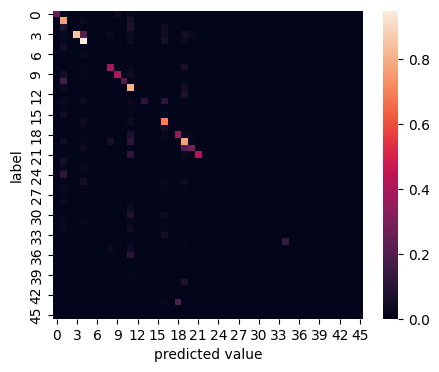

 Running ML(num_words=3000, model_name=multinomial_nb) ...
단어 개수:  3000
상위 10개 클래스:  [ 4  3  1 19 11 16  9  0 21 13]
[multinomial_nb] Accuracy: 0.6874 | F1: 0.6266


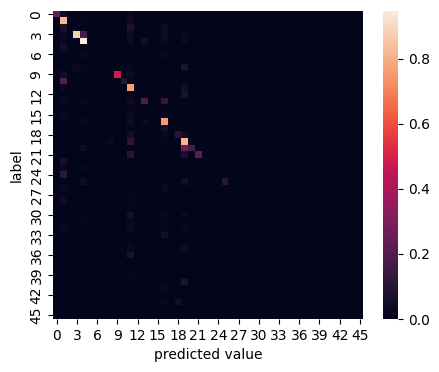

 Running ML(num_words=6000, model_name=multinomial_nb) ...
단어 개수:  6000
상위 10개 클래스:  [ 4  3 19  1 11 16  9 13 20 25]
[multinomial_nb] Accuracy: 0.6692 | F1: 0.5939


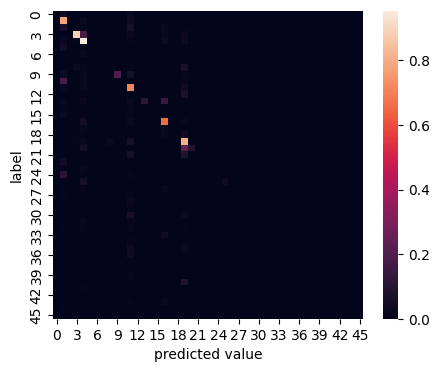

 Running ML(num_words=10000, model_name=multinomial_nb) ...
단어 개수:  10000
상위 10개 클래스:  [ 4  3 19  1 11 16  9 20 25 13]
[multinomial_nb] Accuracy: 0.6567 | F1: 0.5764


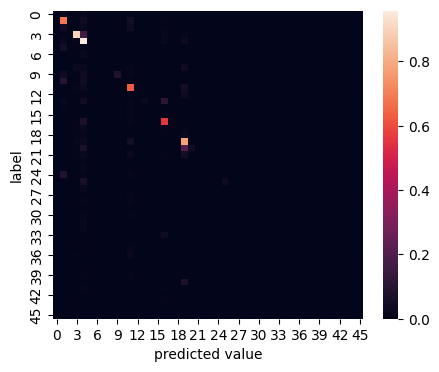

 Running ML(num_words=None, model_name=multinomial_nb) ...
단어 개수:  None
상위 10개 클래스:  [ 4  3 19 11  1 16 45 13 20 18]
[multinomial_nb] Accuracy: 0.5997 | F1: 0.5046


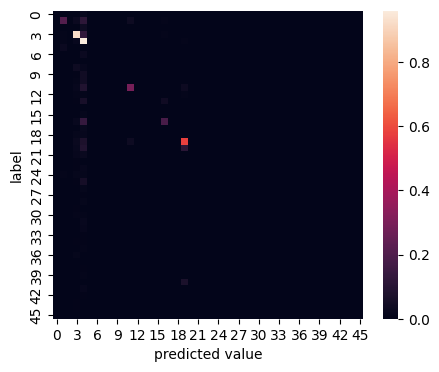

In [124]:
MNB_acc, MNB_f1 = run(num_words_list, model_name='multinomial_nb')

In [133]:
MNB_acc

[0.6856634016028496,
 0.6874443455031166,
 0.6691896705253785,
 0.6567230632235085,
 0.5997328584149599]

In [128]:
MNB_f1

[0.6365038314524903,
 0.6266168450864102,
 0.593850934886101,
 0.5764467518778252,
 0.5045670886188423]

### 2. ComplementNB

num_words = 1000, 3000, 6000, 10000, None
 
Acc: 0.760 (num_words=6000)  
F1: 0.745 (num_words=6000)  

 Running ML(num_words=1000, model_name=complement_nb) ...
단어 개수:  1000
상위 10개 클래스:  [ 9  4  3 34 19 44 11  1 16 10]
[complement_nb] Accuracy: 0.7346 | F1: 0.6973


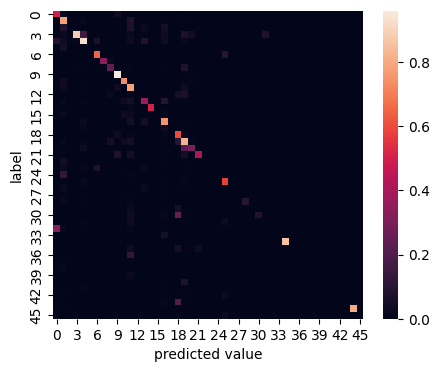

 Running ML(num_words=3000, model_name=complement_nb) ...
단어 개수:  3000
상위 10개 클래스:  [45  4  9  3 26 34  6  1 10 44]
[complement_nb] Accuracy: 0.7645 | F1: 0.7370


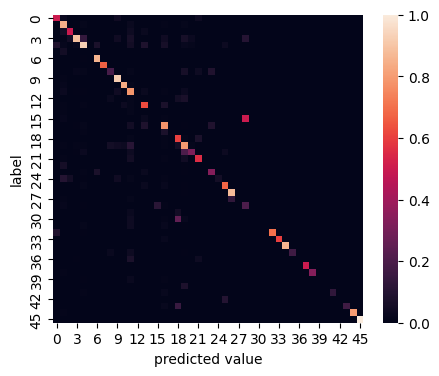

 Running ML(num_words=6000, model_name=complement_nb) ...
단어 개수:  6000
상위 10개 클래스:  [45  4  9  3 26  1 33 44 19 16]
[complement_nb] Accuracy: 0.7689 | F1: 0.7439


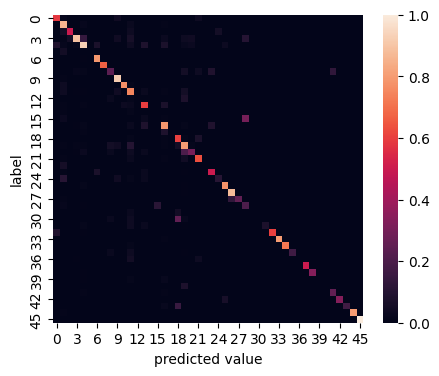

 Running ML(num_words=10000, model_name=complement_nb) ...
단어 개수:  10000
상위 10개 클래스:  [45  6  4  9  3  1 26 33 44 10]
[complement_nb] Accuracy: 0.7707 | F1: 0.7457


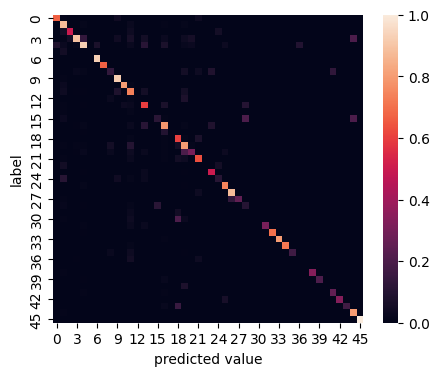

 Running ML(num_words=None, model_name=complement_nb) ...
단어 개수:  None
상위 10개 클래스:  [45  4  3  9  1 26  6 44 33 32]
[complement_nb] Accuracy: 0.7649 | F1: 0.7347


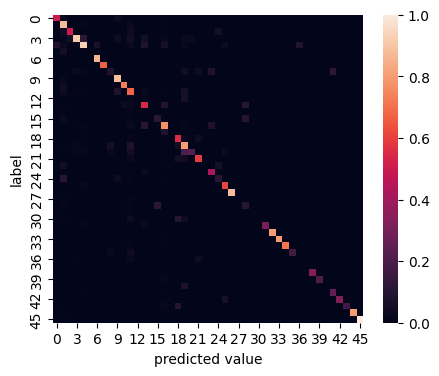

In [135]:
CNB_acc, CNB_f1 = run(num_words_list, model_name='complement_nb')

CNB_acc

In [137]:
CNB_f1

[0.6972989886481723,
 0.7369718160654114,
 0.7438553082323319,
 0.7456682614453047,
 0.7346534179503126]

### 3. Logistic Regression

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.798 (num_words=3000)  
F1: 0.777 (num_words=3000)  

 Running ML(num_words=1000, model_name=logistic_regression) ...
단어 개수:  1000
상위 10개 클래스:  [ 3  4  9 25  1 44 11 16 10 19]
[logistic_regression] Accuracy: 0.7801 | F1: 0.7497


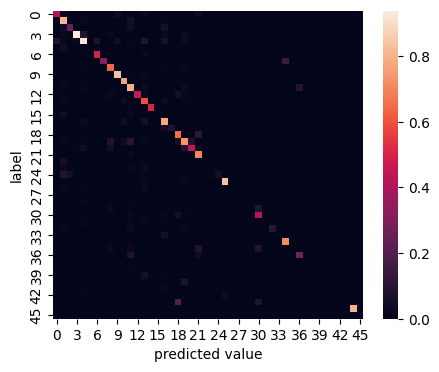

 Running ML(num_words=3000, model_name=logistic_regression) ...
단어 개수:  3000
상위 10개 클래스:  [45  3  4  9  1 11 10 44 16  6]
[logistic_regression] Accuracy: 0.7988 | F1: 0.7776


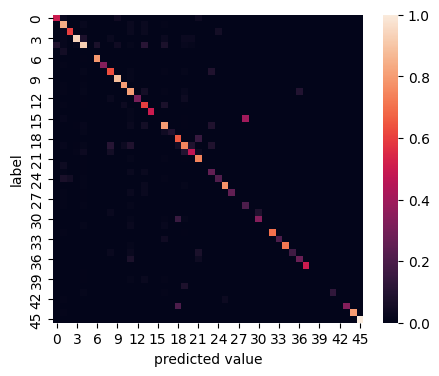

 Running ML(num_words=6000, model_name=logistic_regression) ...
단어 개수:  6000
상위 10개 클래스:  [45  3  4  9  1 11 44 16  6 21]
[logistic_regression] Accuracy: 0.7974 | F1: 0.7749


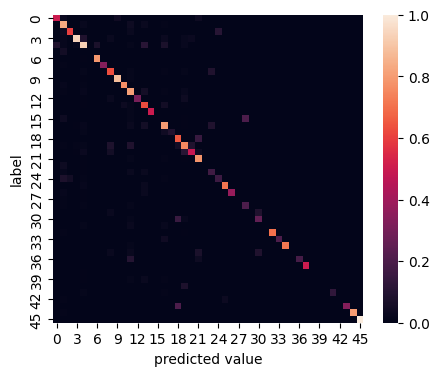

 Running ML(num_words=10000, model_name=logistic_regression) ...
단어 개수:  10000
상위 10개 클래스:  [45  3  4  9  1 11 44 16  6 10]
[logistic_regression] Accuracy: 0.7952 | F1: 0.7728


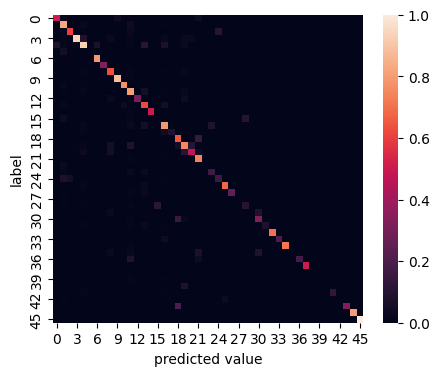

 Running ML(num_words=None, model_name=logistic_regression) ...
단어 개수:  None
상위 10개 클래스:  [45  3  4  9  1 11 44  6 16 21]
[logistic_regression] Accuracy: 0.7921 | F1: 0.7674


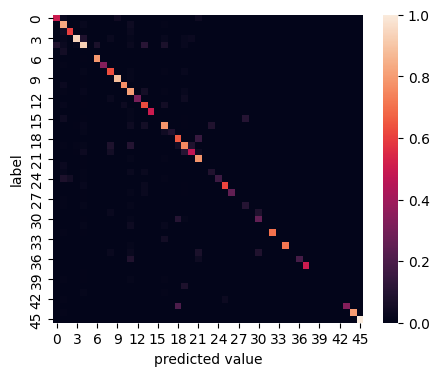

In [141]:
LR_acc, LR_f1 = run(num_words_list, model_name='logistic_regression')

In [142]:
LR_acc

[0.780053428317008,
 0.798753339269813,
 0.7974176313446126,
 0.7951914514692787,
 0.7920747996438112]

In [143]:
LR_f1

[0.749652605882831,
 0.7775953897921586,
 0.7749176142747434,
 0.7727935299669956,
 0.7674140243009971]

### 4. Support Vector Machine

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.70 (num_words=None)  
F1: 0.70 (num_words=None)  

 Running ML(num_words=1000, model_name=linear_svc) ...
단어 개수:  1000
상위 10개 클래스:  [45 14  6  9  3 25  4 10 21 43]
[linear_svc] Accuracy: 0.8148 | F1: 0.8050


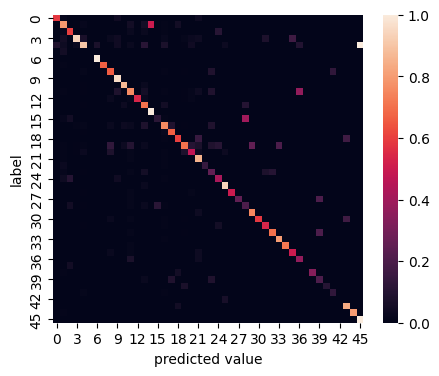

 Running ML(num_words=3000, model_name=linear_svc) ...
단어 개수:  3000
상위 10개 클래스:  [45 43 42  6  3 10 21  4  9 26]
[linear_svc] Accuracy: 0.8290 | F1: 0.8229


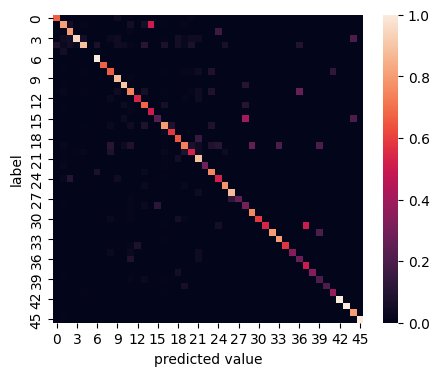

 Running ML(num_words=6000, model_name=linear_svc) ...
단어 개수:  6000
상위 10개 클래스:  [45 43 42  6 14 29  3 10 21  4]
[linear_svc] Accuracy: 0.8281 | F1: 0.8218


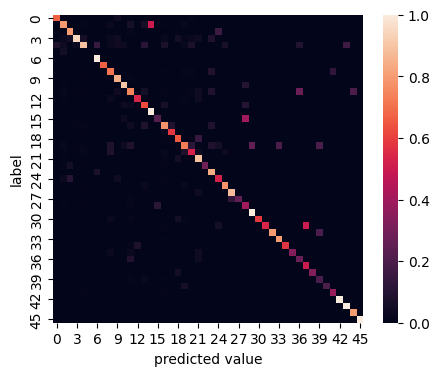

 Running ML(num_words=10000, model_name=linear_svc) ...
단어 개수:  10000
상위 10개 클래스:  [45 29 43 14  3  6 10  4 21 26]
[linear_svc] Accuracy: 0.8299 | F1: 0.8237


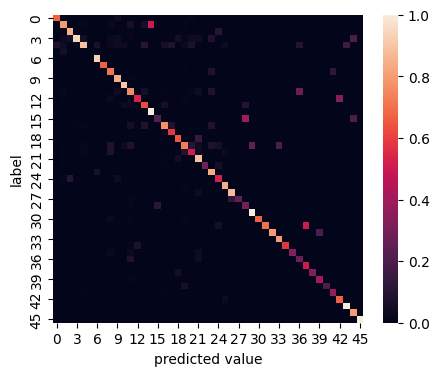

 Running ML(num_words=None, model_name=linear_svc) ...
단어 개수:  None
상위 10개 클래스:  [45 43 14 29  3  6 32 10  4 21]
[linear_svc] Accuracy: 0.8295 | F1: 0.8237


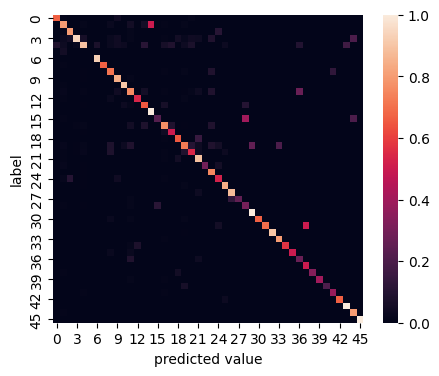

In [146]:
SVM_acc, SVM_f1 = run(num_words_list, model_name='linear_svc')

In [147]:
SVM_acc

[0.8147818343722173,
 0.8290293855743545,
 0.8281389136242209,
 0.8299198575244879,
 0.8294746215494212]

In [148]:
SVM_f1

[0.8049987324652461,
 0.8228793821800253,
 0.8218435536431363,
 0.8236882254849623,
 0.823667985526927]

### 5. Decision Tree

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.823 (num_words=10000)  
F1: 0.824 (num_words=10000)  

 Running ML(num_words=1000, model_name=decision_tree) ...
단어 개수:  1000
상위 10개 클래스:  [45  3 10 44  4  0  9 43  1  6]
[decision_tree] Accuracy: 0.6866 | F1: 0.6824


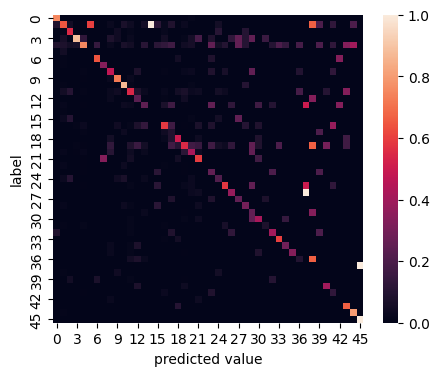

 Running ML(num_words=3000, model_name=decision_tree) ...
단어 개수:  3000
상위 10개 클래스:  [45 33 37 10  3  9 26  4 32  1]
[decision_tree] Accuracy: 0.6995 | F1: 0.6947


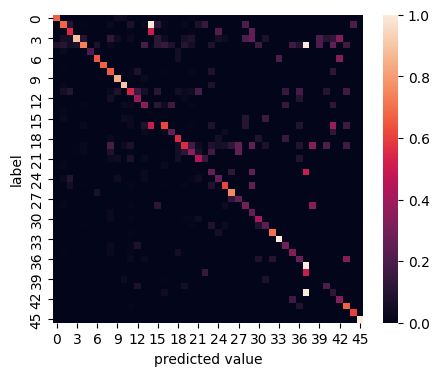

 Running ML(num_words=6000, model_name=decision_tree) ...
단어 개수:  6000
상위 10개 클래스:  [45 33 26 10  3  9 44 32 29  4]
[decision_tree] Accuracy: 0.6857 | F1: 0.6828


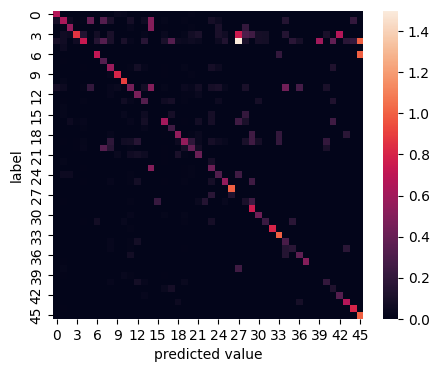

 Running ML(num_words=10000, model_name=decision_tree) ...
단어 개수:  10000
상위 10개 클래스:  [45 33 37  3 26  9 44 10  4 32]
[decision_tree] Accuracy: 0.6932 | F1: 0.6878


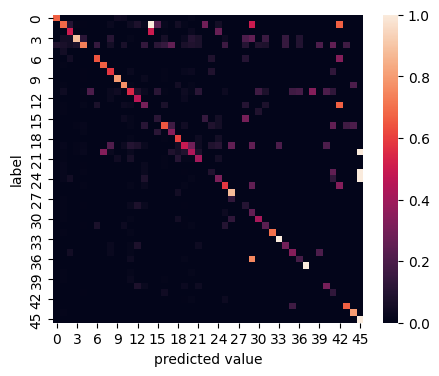

 Running ML(num_words=None, model_name=decision_tree) ...
단어 개수:  None
상위 10개 클래스:  [45 37 33  3 26 44  6 10  4  9]
[decision_tree] Accuracy: 0.7048 | F1: 0.7001


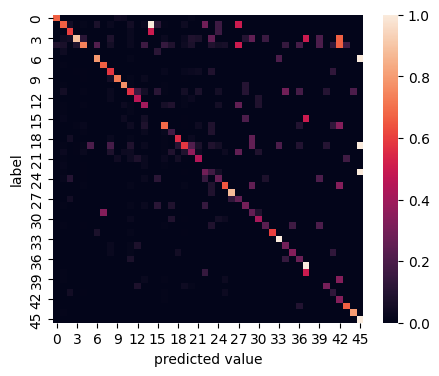

In [150]:
DT_acc, DT_f1 = run(num_words_list, model_name='decision_tree')

In [151]:
DT_acc

[0.686553873552983,
 0.6994657168299199,
 0.6856634016028496,
 0.6932324131789849,
 0.7048085485307213]

In [152]:
DT_f1

[0.6823518831786771,
 0.694688789960361,
 0.6827739807473285,
 0.6877699534571604,
 0.7001324245678012]

### 6. Random Forest

n_estimators=100

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.774 (num_words=3000)  
F1: 0.754 (num_words=3000)  

 Running ML(num_words=1000, model_name=random_forest) ...
단어 개수:  1000
상위 10개 클래스:  [45  3  4 10  1  9 33 44 11 19]
[random_forest] Accuracy: 0.7716 | F1: 0.7502


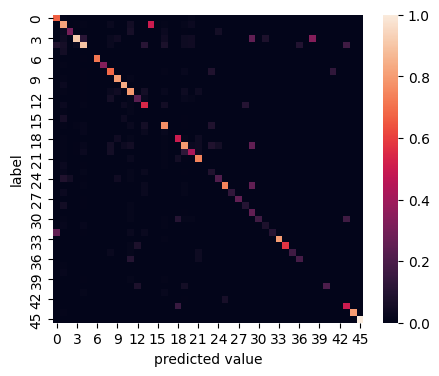

 Running ML(num_words=3000, model_name=random_forest) ...
단어 개수:  3000
상위 10개 클래스:  [45  3  4 11  1 44 10 33 19  9]
[random_forest] Accuracy: 0.7747 | F1: 0.7544


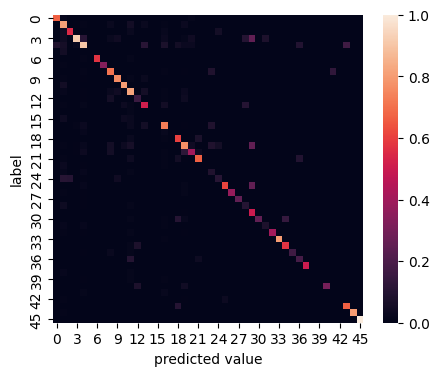

 Running ML(num_words=6000, model_name=random_forest) ...
단어 개수:  6000
상위 10개 클래스:  [45  3  4 33  1 10 44 19  9 11]
[random_forest] Accuracy: 0.7609 | F1: 0.7375


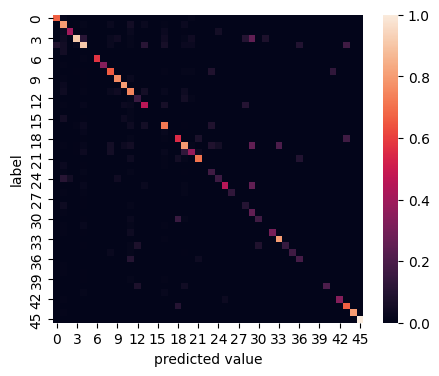

 Running ML(num_words=10000, model_name=random_forest) ...
단어 개수:  10000
상위 10개 클래스:  [45  4  3 11 33 44  1 19 10 16]
[random_forest] Accuracy: 0.7578 | F1: 0.7335


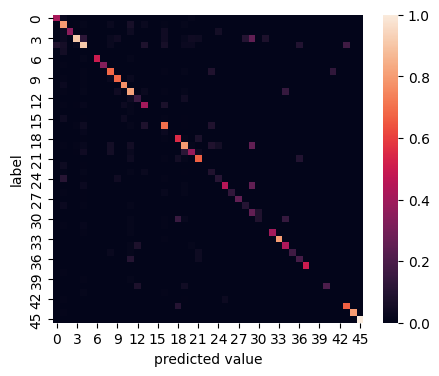

 Running ML(num_words=None, model_name=random_forest) ...
단어 개수:  None
상위 10개 클래스:  [45  3  4 33 44  1 11 19  8  9]
[random_forest] Accuracy: 0.7373 | F1: 0.7109


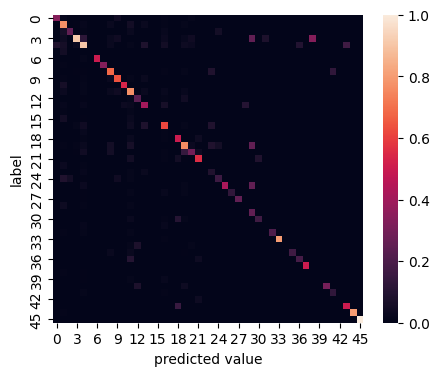

In [153]:
RF_acc, RF_f1 = run(num_words_list, model_name='random_forest')

In [154]:
RF_acc

[0.7715939447907391,
 0.7747105966162066,
 0.7609082813891362,
 0.7577916295636687,
 0.7373107747105966]

In [155]:
RF_f1

[0.7501733307640198,
 0.7543936108025412,
 0.737460914918179,
 0.7334960069453246,
 0.7109356053424638]

### 7. Gradient Boosting

n_estimators=100

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.772 (num_words=None)  
F1: 0.768 (num_words=None)  

 Running ML(num_words=1000, model_name=gradient_boosting) ...
단어 개수:  1000
상위 10개 클래스:  [ 3  6  4 10 44 19 25 16 11 21]
[gradient_boosting] Accuracy: 0.7440 | F1: 0.7369


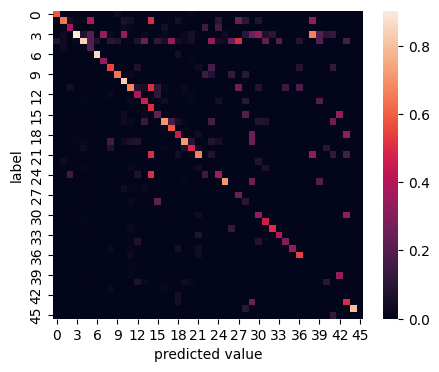

 Running ML(num_words=3000, model_name=gradient_boosting) ...
단어 개수:  3000
상위 10개 클래스:  [45 42 37 14  6  3  4 44  9 33]
[gradient_boosting] Accuracy: 0.7649 | F1: 0.7612


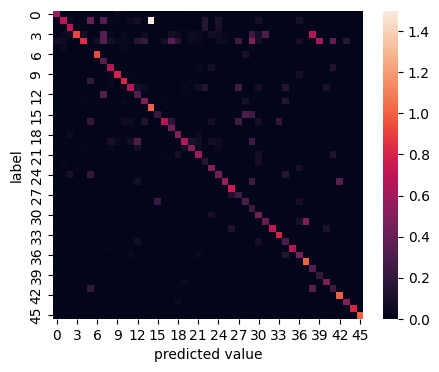

 Running ML(num_words=6000, model_name=gradient_boosting) ...
단어 개수:  6000
상위 10개 클래스:  [45  6  3  4 32 33 44 16 10  9]
[gradient_boosting] Accuracy: 0.7614 | F1: 0.7586


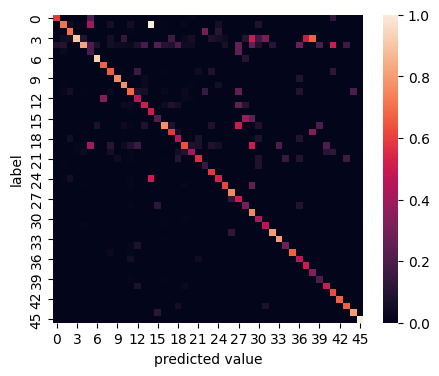

 Running ML(num_words=10000, model_name=gradient_boosting) ...
단어 개수:  10000
상위 10개 클래스:  [45 37 26  6  3 32  9  4 10 44]
[gradient_boosting] Accuracy: 0.7707 | F1: 0.7679


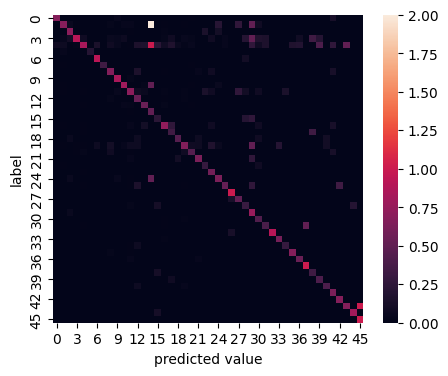

 Running ML(num_words=None, model_name=gradient_boosting) ...
단어 개수:  None
상위 10개 클래스:  [45 37 26 32 33  3  4 44  9 10]
[gradient_boosting] Accuracy: 0.7725 | F1: 0.7680


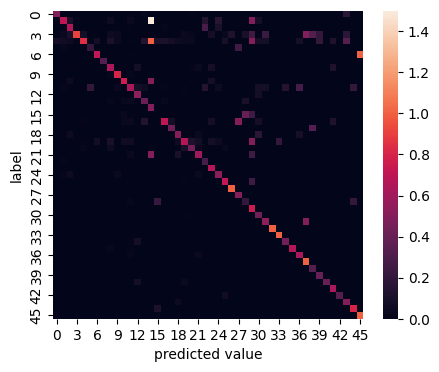

In [156]:
GB_acc, GB_f1 = run(num_words_list, model_name='gradient_boosting')

In [157]:
GB_acc

[0.7439893143365984,
 0.7649154051647373,
 0.761353517364203,
 0.7707034728406055,
 0.7724844167408726]

In [158]:
GB_f1

[0.7369461887967991,
 0.7612374008015098,
 0.7586269035620046,
 0.7679041718927049,
 0.768009130741911]

### 8. Hard Voting

Candidates: Logistic Regression, Random Forest, Linear SVC

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.809 (num_words=3000)  
F1: 0.79 (num_words=3000)  

 Running ML(num_words=1000, model_name=voting) ...
단어 개수:  1000
상위 10개 클래스:  [45  3  4 25  9 10  6  1 21 11]
[voting] Accuracy: 0.7961 | F1: 0.7730


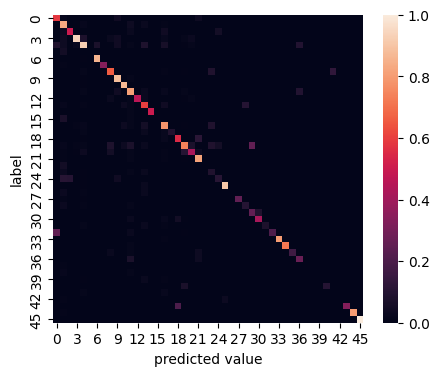

 Running ML(num_words=3000, model_name=voting) ...
단어 개수:  3000
상위 10개 클래스:  [45  3  6  4  9 10  1 43 11 33]
[voting] Accuracy: 0.8099 | F1: 0.7930


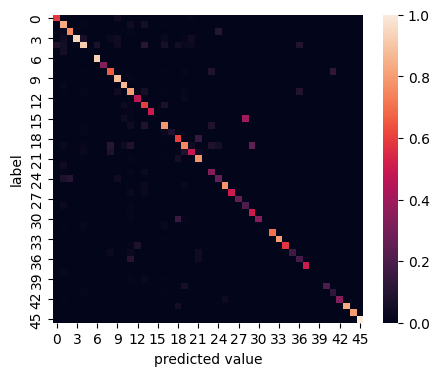

 Running ML(num_words=6000, model_name=voting) ...
단어 개수:  6000
상위 10개 클래스:  [45  3  4  6  9 11  1 21 33 10]
[voting] Accuracy: 0.8041 | F1: 0.7853


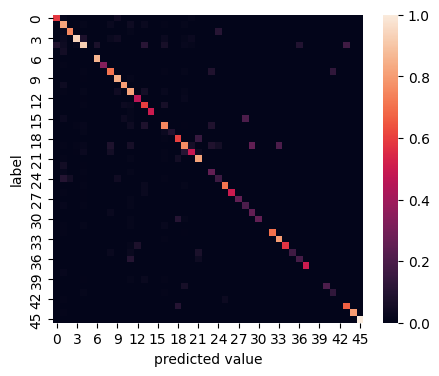

 Running ML(num_words=10000, model_name=voting) ...
단어 개수:  10000
상위 10개 클래스:  [45  3  6  4  9 43 11  1 33 44]
[voting] Accuracy: 0.8001 | F1: 0.7824


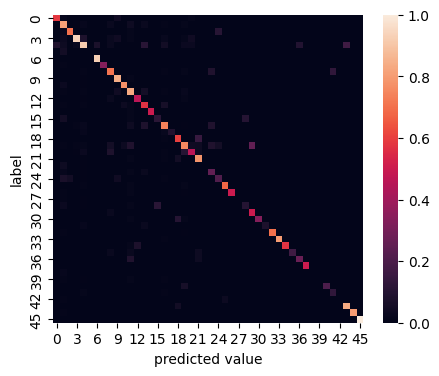

 Running ML(num_words=None, model_name=voting) ...
단어 개수:  None
상위 10개 클래스:  [45  3  4  6  9 43  1 21 11 44]
[voting] Accuracy: 0.7934 | F1: 0.7739


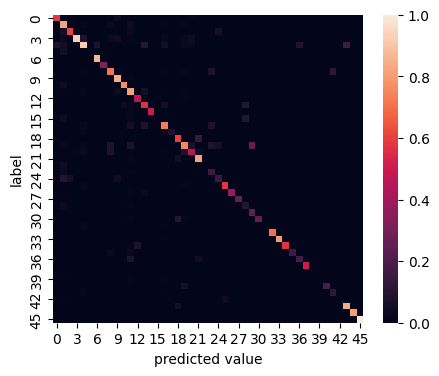

In [160]:
Vt_acc, Vt_f1 = run(num_words_list, model_name='hard_voting')

In [161]:
Vt_acc

[0.7960819234194123,
 0.8098842386464826,
 0.8040961709706145,
 0.8000890471950134,
 0.7934105075690115]

In [162]:
Vt_f1

[0.7730461784047236,
 0.7929627198147974,
 0.785336008245069,
 0.7824188959635294,
 0.7738706071579513]

In [179]:
num_list = [1000, 3000, 6000, 10000, "Full"]

In [184]:
acc_data = {
    "Multinomial NB": MNB_acc,
    "Complement NB": CNB_acc,
    "Logistic Regression": LR_acc,
    "Support Vector Machine": SVM_acc,
    "Decision Tree": DT_acc,
    "Random Forest": RF_acc,
    "Gradient Boosting": GB_acc,
    "Voting(LR, RF, SVC)": Vt_acc,}

acc_df = pd.DataFrame(acc_data, index=num_list).T

In [185]:

f1_data = {
    "Multinomial NB": MNB_f1,
    "Complement NB": CNB_f1,
    "Logistic Regression": LR_f1,
    "Support Vector Machine": SVM_f1,
    "Decision Tree": DT_f1,
    "Random Forest": RF_f1,
    "Gradient Boosting": GB_f1,
    "Voting(LR, RF, SVC)": Vt_f1,}

f1_df = pd.DataFrame(f1_data, index=num_list).T

In [186]:
acc_df

,1000,3000,6000,10000,Full
Multinomial NB,0.685663,0.687444,0.669190,0.656723,0.599733
Complement NB,0.734639,0.764470,0.768923,0.770703,0.764915
Logistic Regression,0.780053,0.798753,0.797418,0.795191,0.792075
Support Vector Machine,0.814782,0.829029,0.828139,0.829920,0.829475
Decision Tree,0.686554,0.699466,0.685663,0.693232,0.704809
Random Forest,0.771594,0.774711,0.760908,0.757792,0.737311
Gradient Boosting,0.743989,0.764915,0.761354,0.770703,0.772484
"Voting(LR, RF, SVC)",0.796082,0.809884,0.804096,0.800089,0.793411


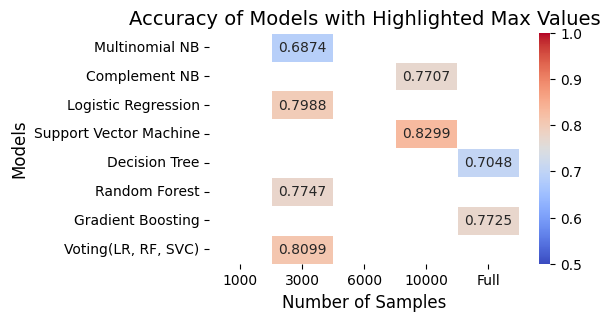

In [232]:
plt.figure(figsize=(5, 3))
sns.heatmap(acc_df.set_index(acc_df.index), annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5, 
            cbar=True, vmax=1.0, vmin=0.5, mask=acc_df.set_index(acc_df.index) != acc_df.set_index(acc_df.index).max(axis=1).values[:, None])

plt.title('Accuracy of Models with Highlighted Max Values', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

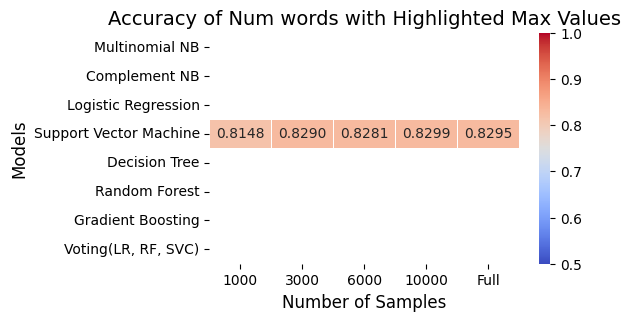

In [233]:
plt.figure(figsize=(5, 3))
sns.heatmap(acc_df.set_index(acc_df.index), annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5,
            cbar=True, vmax=1.0, vmin=0.5, mask=acc_df.set_index(acc_df.index) != acc_df.set_index(acc_df.index).max(axis=0))

plt.title('Accuracy of Num words with Highlighted Max Values', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

In [234]:
f1_df

,1000,3000,6000,10000,Full
Multinomial NB,0.636504,0.626617,0.593851,0.576447,0.504567
Complement NB,0.697299,0.736972,0.743855,0.745668,0.734653
Logistic Regression,0.749653,0.777595,0.774918,0.772794,0.767414
Support Vector Machine,0.804999,0.822879,0.821844,0.823688,0.823668
Decision Tree,0.682352,0.694689,0.682774,0.687770,0.700132
Random Forest,0.750173,0.754394,0.737461,0.733496,0.710936
Gradient Boosting,0.736946,0.761237,0.758627,0.767904,0.768009
"Voting(LR, RF, SVC)",0.773046,0.792963,0.785336,0.782419,0.773871


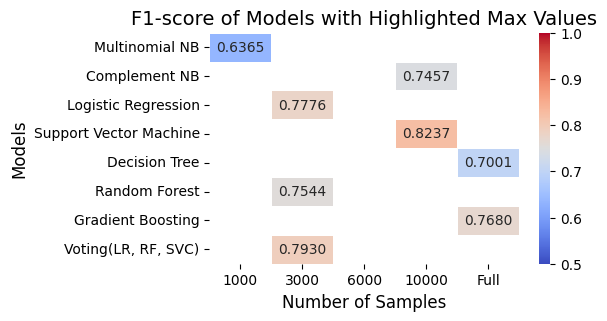

In [238]:
plt.figure(figsize=(5, 3))
sns.heatmap(f1_df.set_index(f1_df.index), annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5, 
            cbar=True, vmax=1.0, vmin=0.5, mask=f1_df.set_index(f1_df.index) != f1_df.set_index(f1_df.index).max(axis=1).values[:, None])

plt.title('F1-score of Models with Highlighted Max Values', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

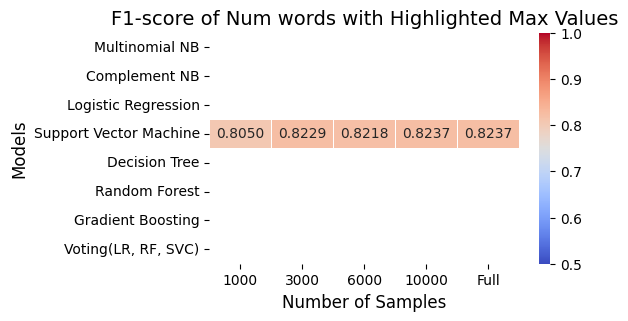

In [239]:
plt.figure(figsize=(5, 3))
sns.heatmap(f1_df.set_index(acc_df.index), annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5,
            cbar=True, vmax=1.0, vmin=0.5, mask=f1_df.set_index(acc_df.index) != f1_df.set_index(acc_df.index).max(axis=0))

plt.title('F1-score of Num words with Highlighted Max Values', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

### 1차 관찰 분석

현재 해결해야 할 문제는 약 46
멀티노미얼 나이브 베이즈랑 결정 트리의 경우 분류 클래스가 약 40여개로 많은 문제로 인해서 성능이 좋지 않은 것을 확인했음.

특히, Logistic Regression과 Random Forest 알고리즘이 Support Vector Machine(성능 1등)에 비해 성능 수준이 낮은데, 이 과정에서 하드 보팅을 사용했기 때문에, LR과 RF가 비슷한 수준에서, 비슷한 양상으로 예측한 경우 SVM의 예측이 무시당할 수 있음

&rightarrow; 소프트 보팅을 실험해보자

### Accuracy:  
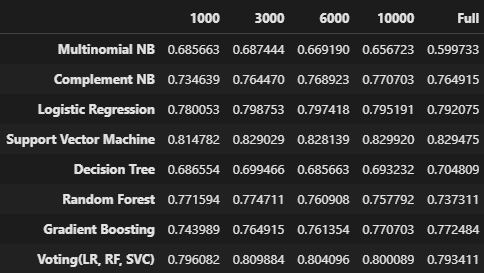

### 각 모델 별 최고성능:  
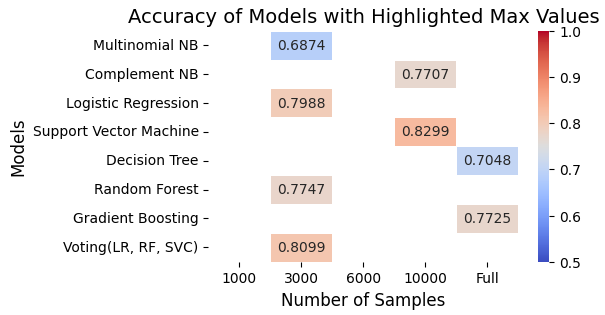

### Num words 별 최고성능:
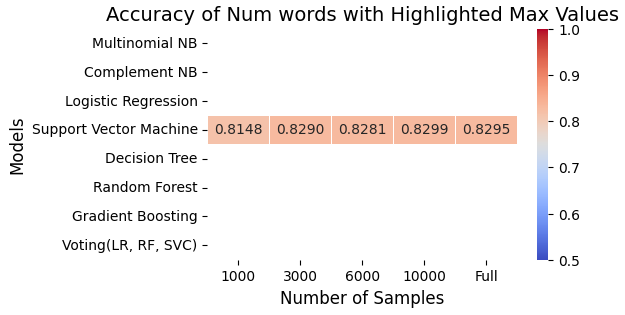

### F1-score:  
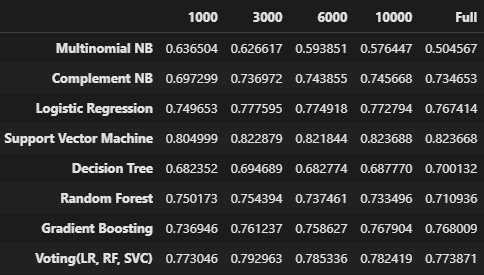

### 각 모델 별 최고성능:  
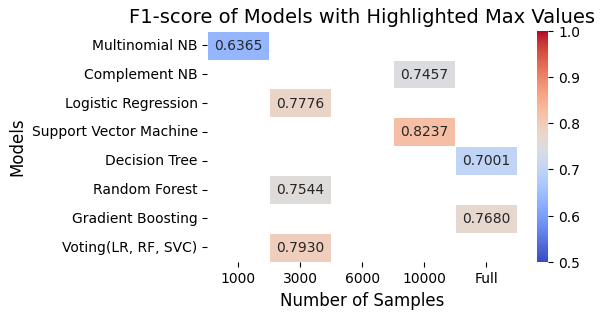

### Num words 별 최고성능:
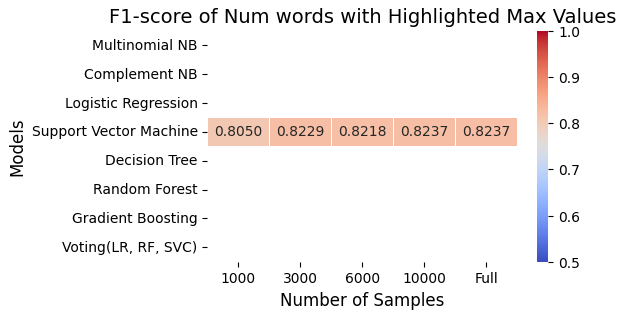

### 9. Soft Voting

Candidates: Logistic Regression, Random Forest, SVC

num_words = 1000, 3000, 6000, 10000, None

Acc: 0.809 (num_words=3000)  
F1: 0.792 (num_words=3000)  

성능이 좋지 않다.

In [ ]:
SoftVT_acc, SoftVT_f1 = run(num_words_list, model_name='soft_voting')

In [ ]:
SoftVT_acc

In [ ]:
SoftVT_f1

### 딥러닝 모델과 비교하기: 1D CNN, LSTM

훈련 데아터 통계 상 패딩 길이는 325에서 truncate

(전체 데이터 중 약 90퍼센트가 300개 이내의 정수로 인코딩되어 있음)

(아무런 추가 전처리를 가하지 않고 그대로 데이터 불러와 사용)

Best
Acc: 0.68 (num_words=6000)
F1: 0.63 (num_words=6000)

1. 데이터가 신경망이 활약할만한 수준보다는 적은 편이고, (<10000)  
2. Feature engineering 안 했고,  
2. SVM이 제일 성능이 좋은 걸 관찰했을 때, 애초에 선형적으로 분리가 잘 되는 구조라고 예상할 수 있고 이 경우 복잡한 딥러닝 모델이 굳이 필요 없을지도 모름  
3. 모델의 Depth나 Width를 다양하게 실험한 것은 아님. 

In [316]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

In [291]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

In [311]:
max(y_train)

45

In [301]:
lengths = np.array([len(x) for x in x_train])

In [302]:
np.percentile(lengths, 90)

313.0

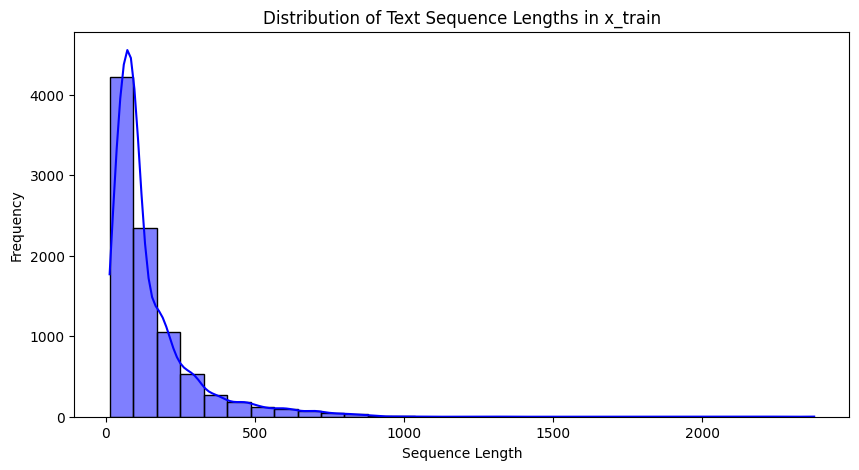

In [303]:
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30, kde=True, color='blue')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Sequence Lengths in x_train")
plt.show()

In [305]:
maxlen = 300

truncated_x_train = [x for x in x_train if len(x) <= maxlen]
padded_x_train = pad_sequences(truncated_x_train, maxlen=maxlen, padding='pre')

truncated_x_test = [x for x in x_test if len(x) <= maxlen]
padded_x_test = pad_sequences(truncated_x_train, maxlen=maxlen, padding='pre', truncating='post')

In [406]:
def DL(num_words=10000, padding_len = 300, embedding_dim = 64, model_name=None):
    (texts, labels), (X_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    
    ## Max 패딩 길이 이하만 보존
    filtered_data = [(x, labels[i]) for i, x in enumerate(texts) if len(x) <= padding_len]
    filtered_x_train, filtered_labels = zip(*filtered_data)
    
    filtered_x_train = list(filtered_x_train)
    filtered_labels = np.array(filtered_labels)
    
    padded_x_train = pad_sequences(filtered_x_train, maxlen=padding_len, padding='pre')
    
    X_train, X_val, y_train, y_val = train_test_split(padded_x_train, filtered_labels, test_size=0.2, random_state=42)
    
    # 모델 선택
    if model_name == "CNN":
        model = keras.Sequential([
            layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=padding_len),
            layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),            
            layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.GlobalMaxPooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(46, activation='softmax')
        ])
    elif model_name == "LSTM":
        model = keras.Sequential([
            layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=padding_len),
            layers.LSTM(64, return_sequences=True),
            layers.BatchNormalization(),
            layers.Dropout(0.5),            
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),            
            layers.Dense(46, activation='softmax')
        ]) 
    else:
        raise ValueError(f"지원되지 않는 모델: {model_name}. 사용 가능한 옵션: {['CNN'] + ['LSTM']}")
    
    # 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    X_test = pad_sequences(X_test, maxlen=padding_len, padding='pre', truncating='post')
    X_test = np.array(X_test, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.int32)
    y_val = np.array(y_val, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)
    
    # 테스트
    history = model.fit(X_train, y_train,
              epochs=20,
              batch_size=64,
              callbacks=[EarlyStopping(monitor='val_loss',
                                       patience=3,
                                       restore_best_weights=True)],
              validation_data = (X_val, y_val),
              verbose=0
             )

    X_test = pad_sequences(X_test, maxlen=padding_len, padding='pre', truncating='post')
    X_test = np.array(X_test, dtype=np.float32)
    
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    # 성능 평가
    
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm /= cm.sum(axis=1) # 정규화
    
    diagonal = np.diag(cm)
    top10 = np.argsort(diagonal)[-10:][::-1]
    print("단어 개수: ", num_words)
    print('상위 10개 클래스: ', top10)
    print(f"[{model_name}] Accuracy: {accuracy:.4f} | F1: {f1:.4f}")
    
    plt.figure(figsize=(5,4))
    heatmap = sns.heatmap(cm, annot=False)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    plt.show()
    
    return history, accuracy, f1

In [386]:
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [387]:
def plot_acc(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [388]:
def run_DL(num_words_list, model_name=None):
    accuracy_list = []
    f1_list = []
    
    for num_words in num_words_list:
        print(f" Running DL(num_words={num_words}, model_name={model_name}) ...")
        history, acc, f1 = DL(num_words=num_words, model_name=model_name)
        accuracy_list.append(acc)
        f1_list.append(f1)
        
        # 롯
        plot_loss(history)
        plot_acc(history)
         
    return history, accuracy_list, f1_list
        
num_words_list = [1000, 3000, 6000, 10000]

 Running DL(num_words=1000, model_name=CNN) ...
71/71 [==============================] - 0s 2ms/step
단어 개수:  1000
상위 10개 클래스:  [ 3  4  1 16 11 19 45 13 20 18]
[CNN] Accuracy: 0.6612 | F1: 0.6122


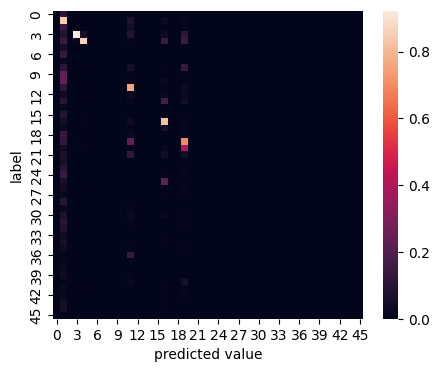

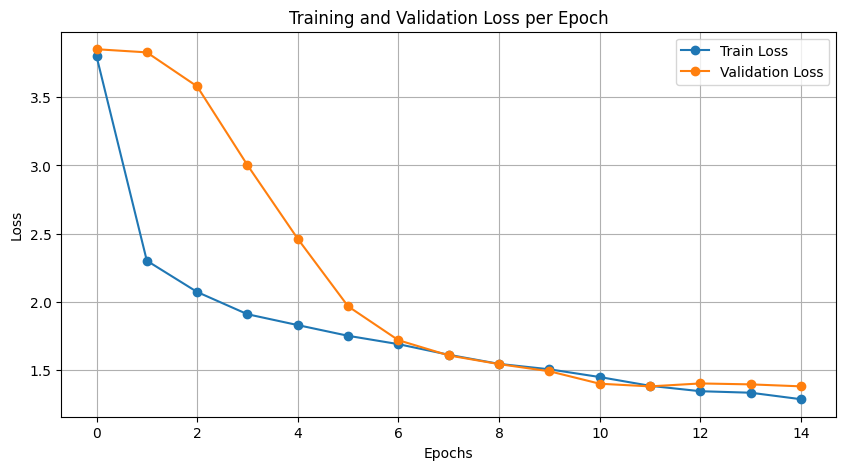

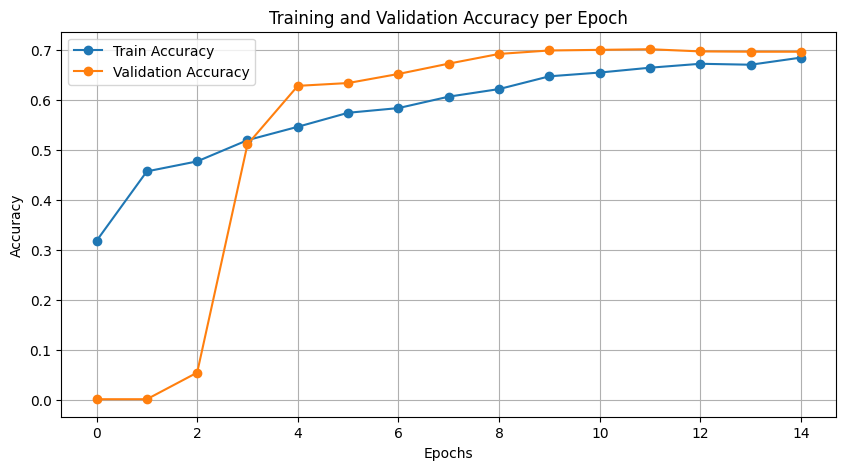

 Running DL(num_words=3000, model_name=CNN) ...
71/71 [==============================] - 0s 2ms/step
단어 개수:  3000
상위 10개 클래스:  [ 3  4 16  1 11 25 19  2 20 13]
[CNN] Accuracy: 0.6723 | F1: 0.6154


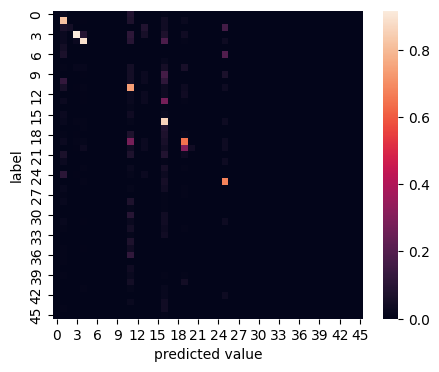

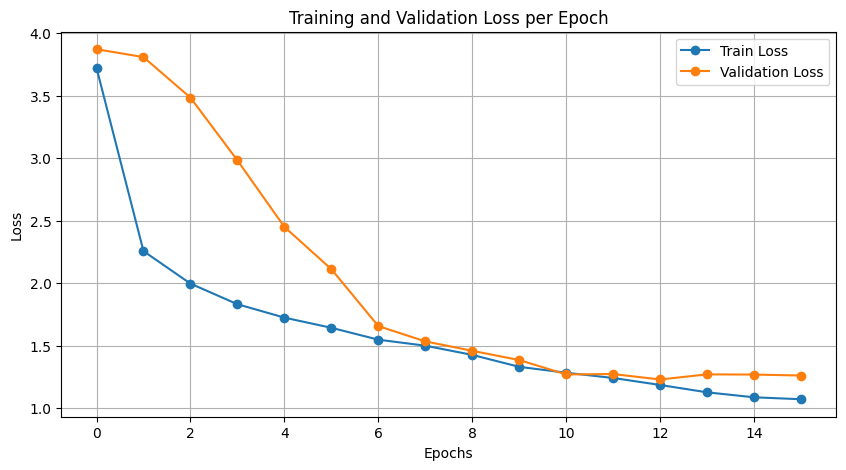

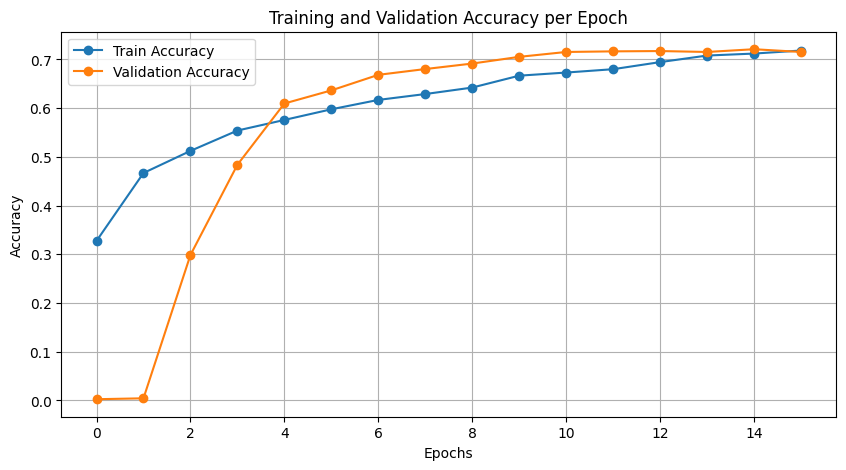

 Running DL(num_words=6000, model_name=CNN) ...
71/71 [==============================] - 0s 2ms/step
단어 개수:  6000
상위 10개 클래스:  [ 3 10  4 16  1 19 25 11  8  9]
[CNN] Accuracy: 0.6843 | F1: 0.6383


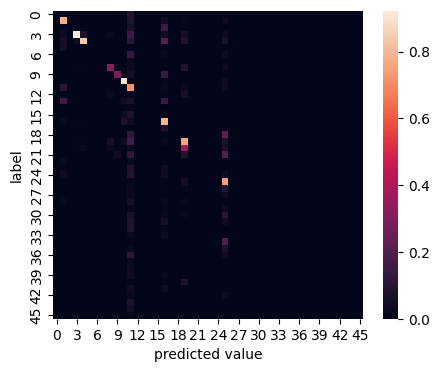

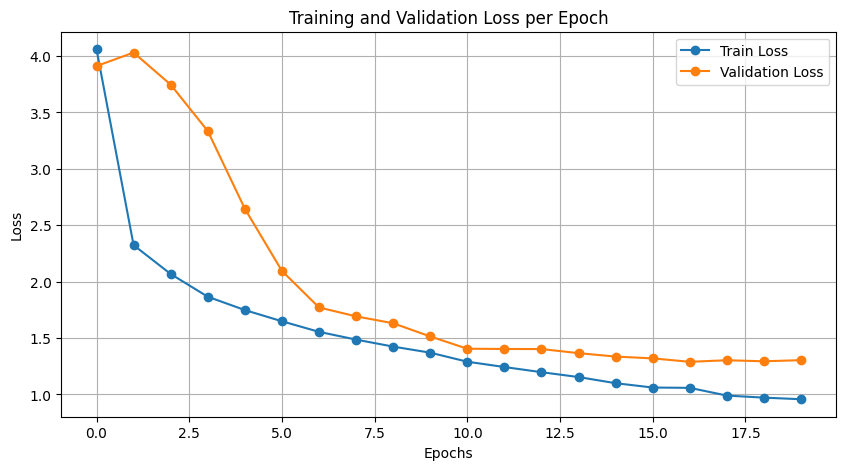

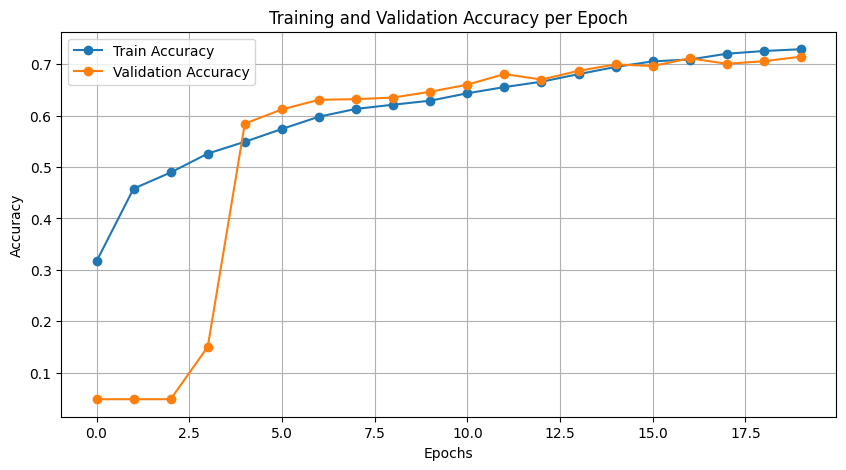

 Running DL(num_words=10000, model_name=CNN) ...
71/71 [==============================] - 0s 2ms/step
단어 개수:  10000
상위 10개 클래스:  [ 3  4  1 19 16 11 25 45 13 18]
[CNN] Accuracy: 0.6465 | F1: 0.5982


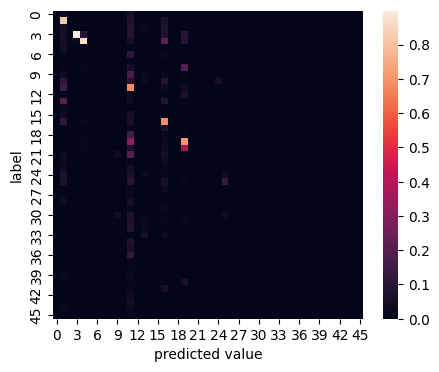

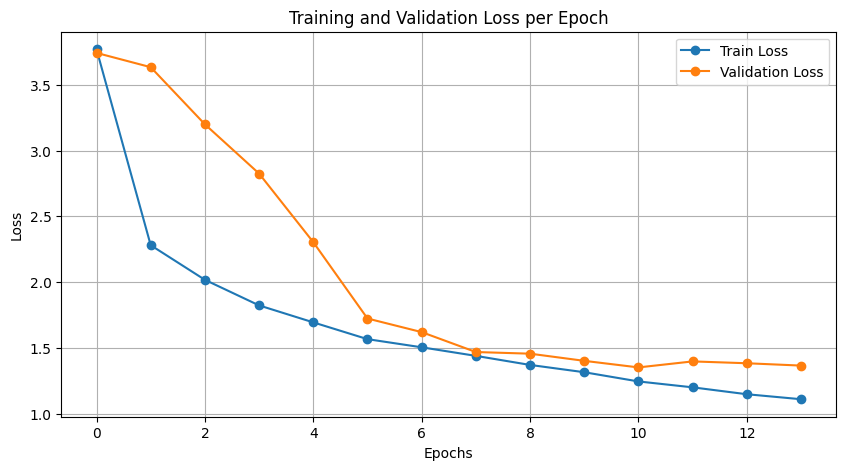

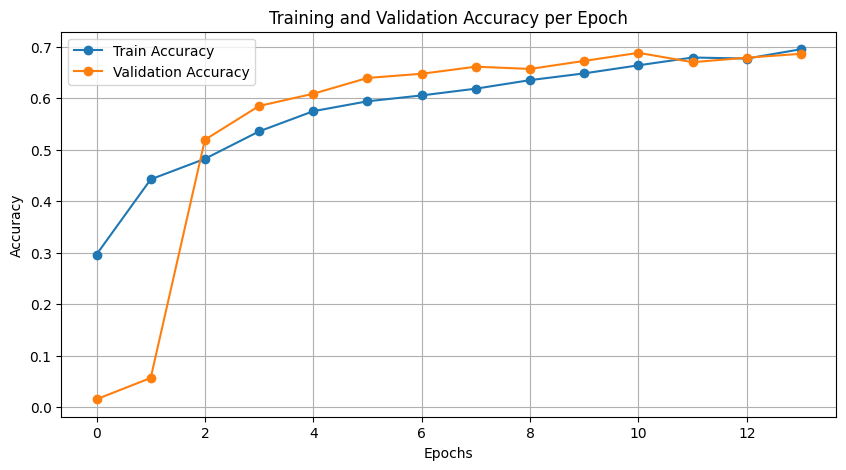

In [407]:
cnn_history, cnn_acc, cnn_f1 = run_DL(num_words_list, model_name='CNN')

In [408]:
cnn_acc

[0.6611754229741763, 0.672306322350846, 0.6843276936776491, 0.6464826357969724]

In [409]:
cnn_f1

[0.6121560113380843,
 0.6154124984663565,
 0.6382806402249555,
 0.5981569674698717]